In [1]:
from sklearn import model_selection
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
import os
import torch
import numpy as np
import pandas as pd
from MicroBiome import MicroBiomeDataSet, Trainer, TrainTester, MultiTrainTester
from SNN import FeedForward, SiameseDataSet, SiameseModel, seed_everything
import seaborn as sns
import numpy as np
import random

# Ignore warning messages
if True:
    import warnings
    warnings.filterwarnings('ignore')

# Load Data

In [2]:
iris = datasets.load_iris()
X = iris.data 
y = iris.target
OneHot = OneHotEncoder(sparse=False)
y = OneHot.fit_transform(y.reshape((y.shape[0], 1)))

In [3]:
y

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0

In [4]:
y.shape

(150, 3)

In [5]:
np.sum(y, axis=0)

array([50., 50., 50.])

# Define and Train Model

In [6]:
seed_everything(69)

In [7]:
MyFeedForward = FeedForward(2, [3])

In [8]:
MyFeedForward

FeedForward(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=3, bias=True)
  )
)

In [9]:
MySNN = SiameseModel(MyFeedForward, predict_unknown = False, class_min_train=5, 
                     n_example_predict=10, learning_rate=1.0e-3, num_epochs = 2, batch_size = 10, rand_seed=69)

In [10]:
# list(MySNN.logistic.parameters()) + list(MySNN.model.parameters())

In [11]:
MyTrainer = Trainer(model = MySNN, scale_X = True, use_pca = True, n_components = 2)

In [12]:
MyTrainTester = TrainTester(MyTrainer, metrics.accuracy_score)

In [13]:
n_splits = 5
MyMultiTrainTester = MultiTrainTester(MyTrainTester, n_splits=n_splits)

In [14]:
MyMultiTrainTester.train(X, y)

Running for split 1 of 5
Training Encoder
#########################################
Epoch 1 of 2
__Training__
2021-03-07 20:22:08
MEAN LOSS: 0.6436427106380462
__Validation__
2021-03-07 20:22:10
MEAN LOSS: 0.6463873569059758
#########################################
Epoch 2 of 2
__Training__
2021-03-07 20:22:10
MEAN LOSS: 0.6389621140003204
__Validation__
2021-03-07 20:22:12
MEAN LOSS: 0.6450647696463725
#########################################
Finished
2021-03-07 20:22:13
Running for split 2 of 5
Training Encoder
#########################################
Epoch 1 of 2
__Training__
2021-03-07 20:22:13
MEAN LOSS: 0.644074229001999
__Validation__
2021-03-07 20:22:15
MEAN LOSS: 0.6468613279176981
#########################################
Epoch 2 of 2
__Training__
2021-03-07 20:22:15
MEAN LOSS: 0.6397131995916366
__Validation__
2021-03-07 20:22:18
MEAN LOSS: 0.6460513854810078
#########################################
Finished
2021-03-07 20:22:18
Running for split 3 of 5
Training Encoder
#

In [15]:
scores_df = pd.DataFrame({'score': MyMultiTrainTester.train_scores, 'stage' : np.repeat('train', n_splits)})
scores_df = scores_df.append(pd.DataFrame({'score': MyMultiTrainTester.test_scores, 'stage' : np.repeat('test', n_splits)}))
scores_df

,score,stage
0,0.933333,train
1,0.933333,train
2,0.950000,train
3,0.916667,train
4,0.916667,train
0,0.933333,test
1,0.933333,test
2,0.866667,test
3,1.000000,test
4,0.966667,test


<AxesSubplot:xlabel='stage', ylabel='score'>

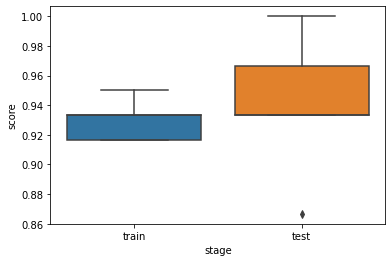

In [16]:
sns.boxplot(data = scores_df, x = 'stage', y = 'score')

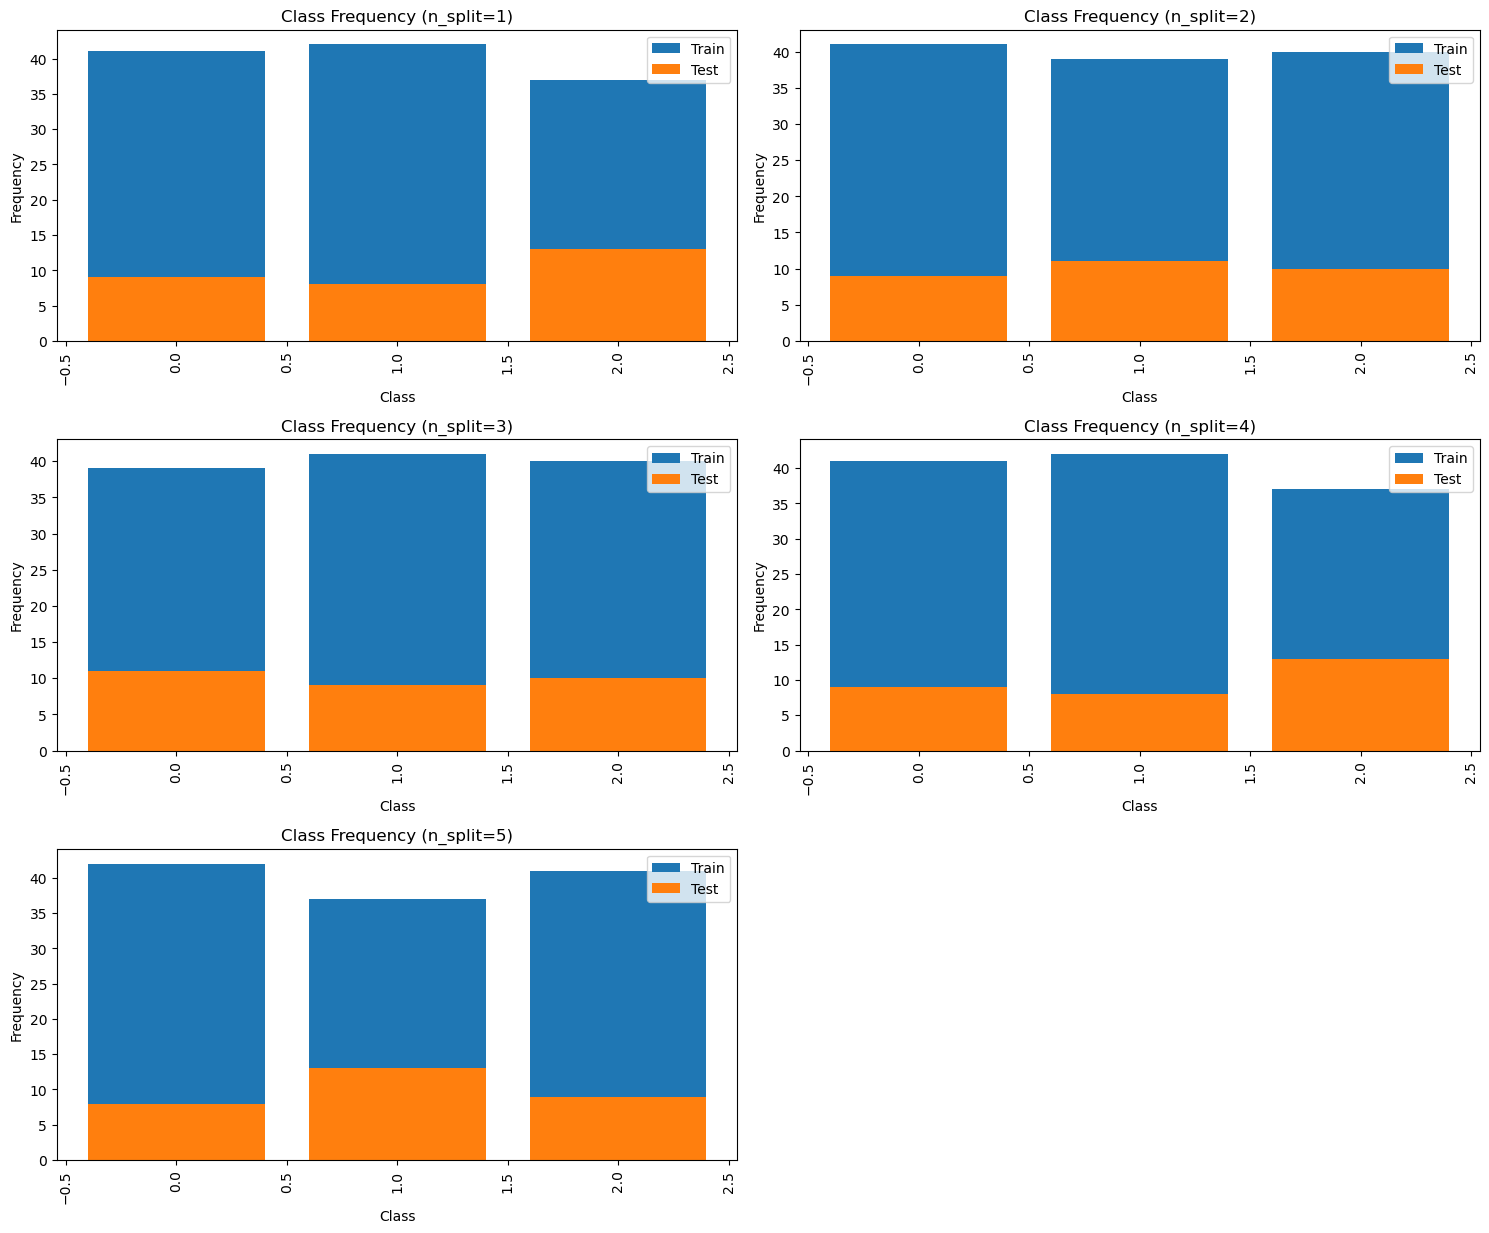

In [17]:
MyMultiTrainTester.plot_class_freq(normalize=True)

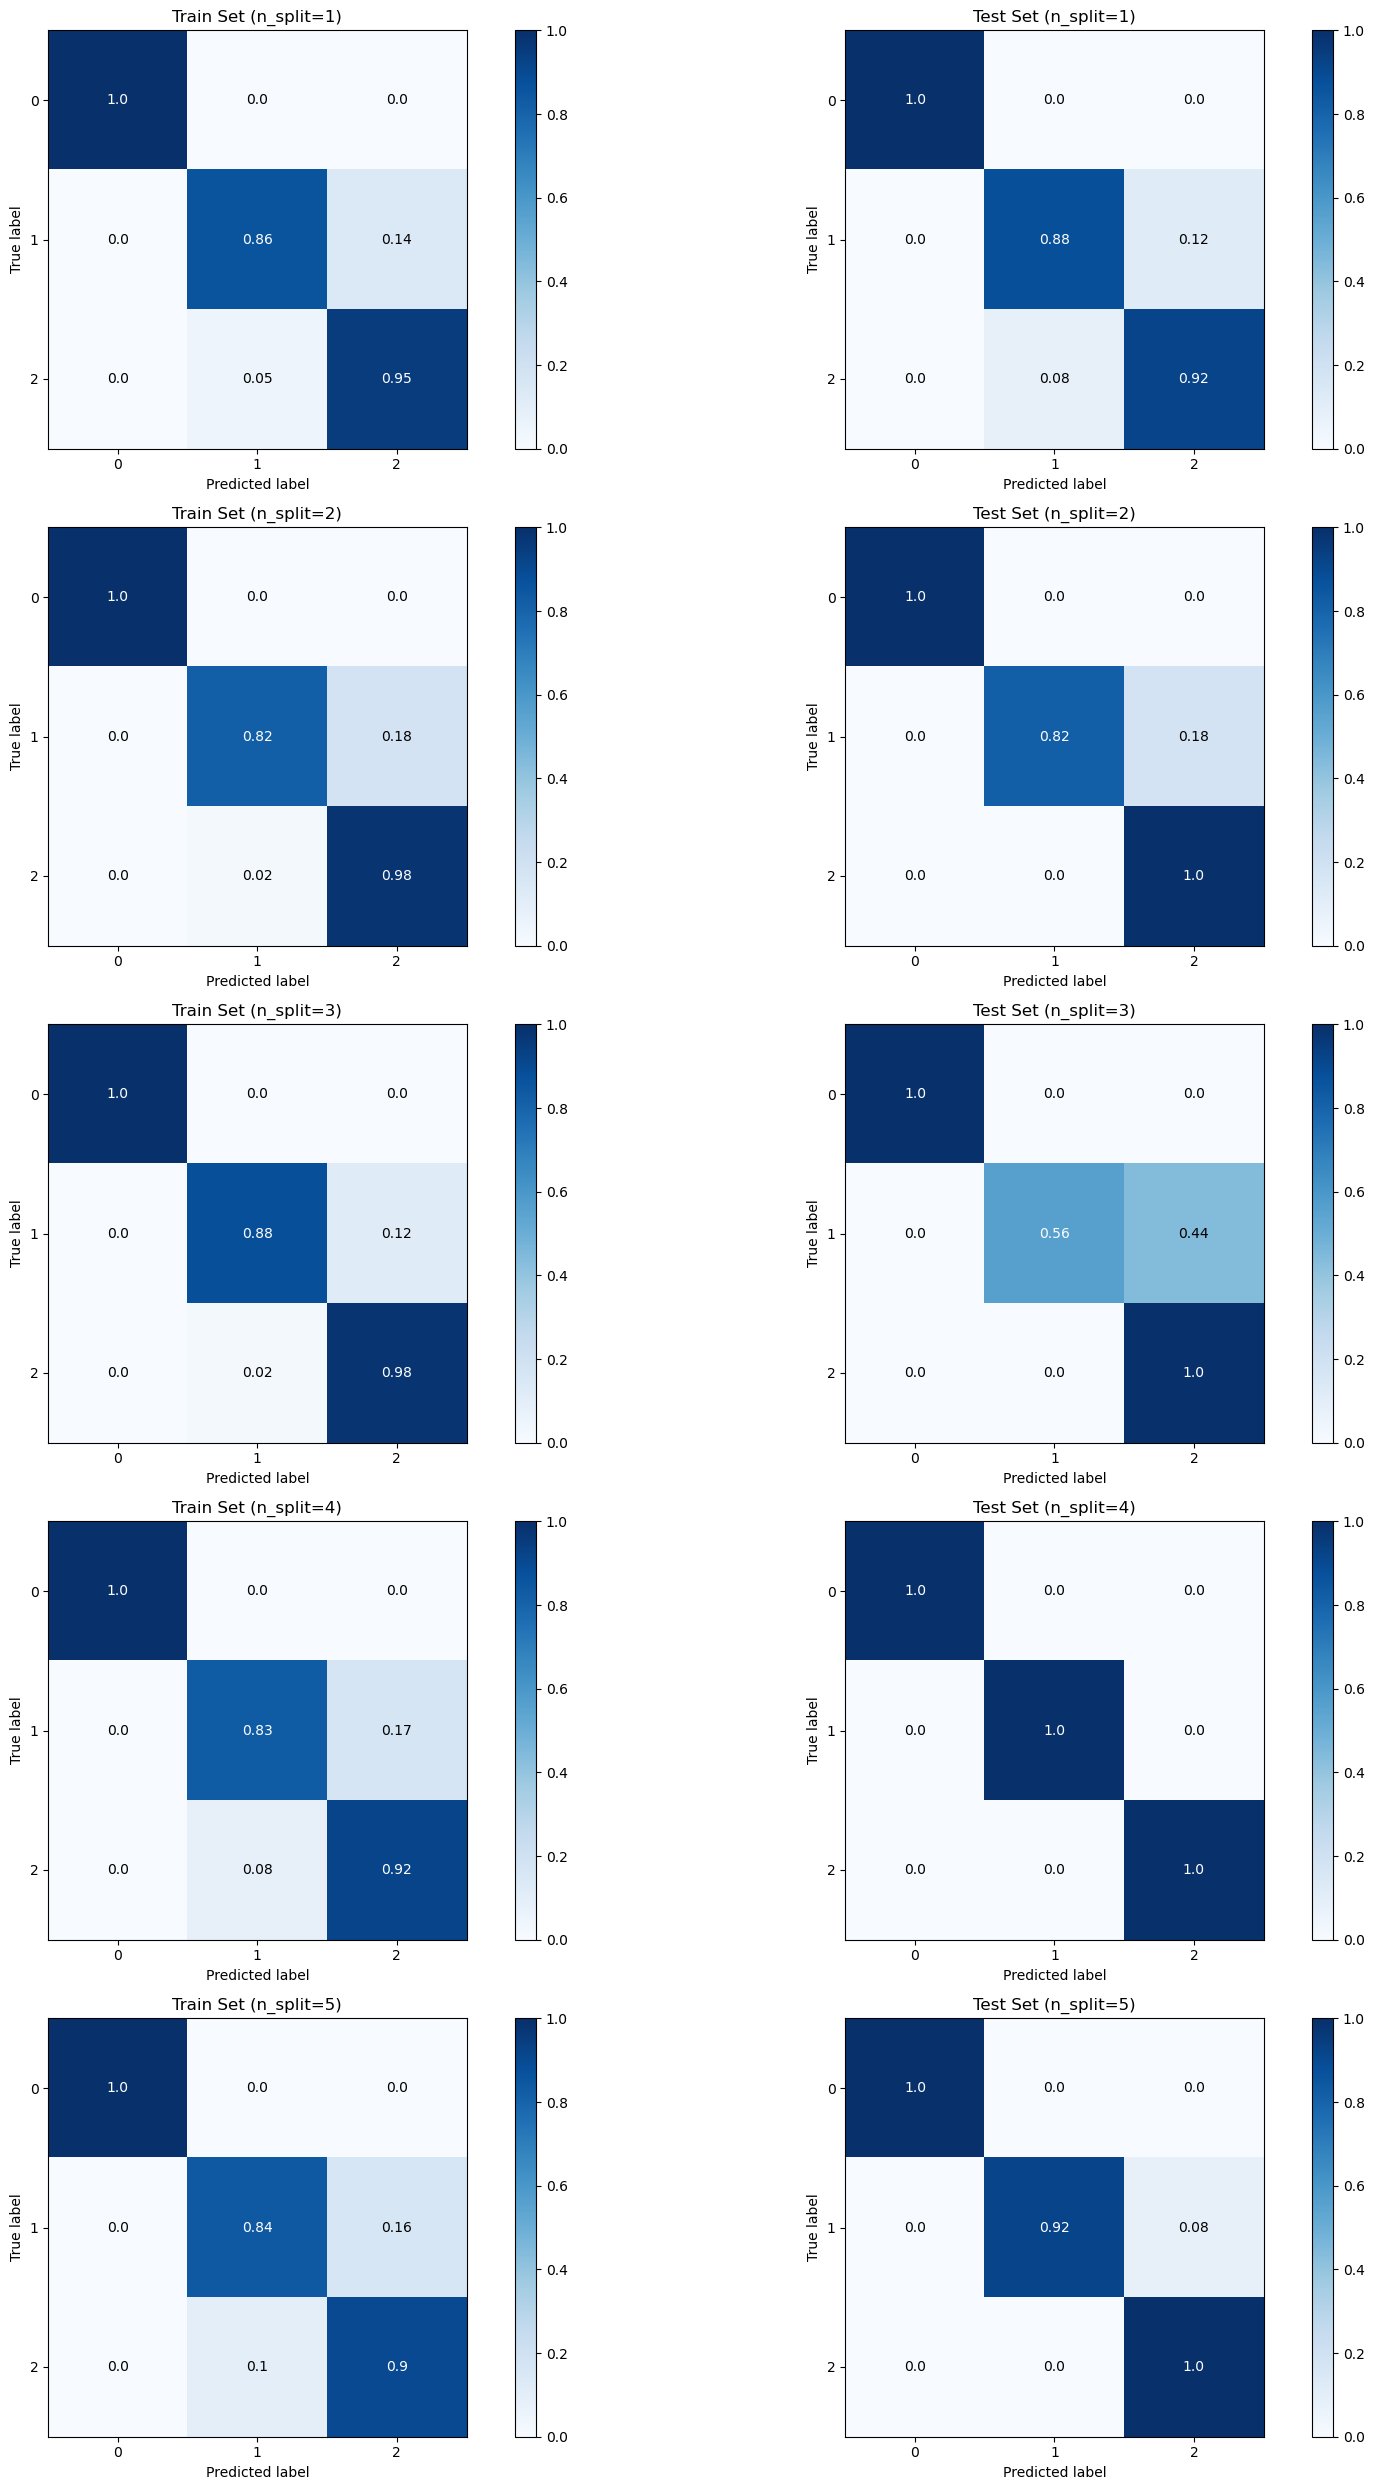

In [18]:
MyMultiTrainTester.plot_confusion(normalize=True)

### Examine Data In Encoded Space

In [19]:
Trainer_use = MyMultiTrainTester.TrainerList[0]

In [20]:
X_transform = Trainer_use.transform_X(X)

In [21]:
X_encoded = Trainer_use.model.model.forward(torch.from_numpy(X_transform).to(torch.float32)).detach().numpy()

In [22]:
# X_encoded = MyFeedForward.forward(torch.from_numpy(X_transform).to(torch.float32)).detach().numpy()

In [23]:
X_encoded.shape

(150, 3)

In [24]:
y_label = Trainer_use.model.one_hot.inverse_transform(y).astype('str')

In [25]:
X_enc_df = pd.DataFrame(X_encoded, columns = ['X' + str(i+1) for i in range(X_encoded.shape[1])])
X_enc_df['y'] = y_label

In [26]:
X_enc_df

,X1,X2,X3,y
0,0.0,2.633830,0.0,0
1,0.0,2.627775,0.0,0
2,0.0,2.696901,0.0,0
3,0.0,2.667390,0.0,0
4,0.0,2.658775,0.0,0
...,...,...,...,...
145,0.0,1.201645,0.0,2
146,0.0,1.342256,0.0,2
147,0.0,1.291266,0.0,2
148,0.0,1.279906,0.0,2


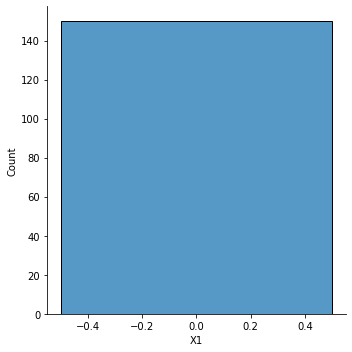

In [27]:
sns.displot(X_enc_df['X1'])

In [28]:
def do_plot(df, x, y, hue):
    if x in df.columns and y in df.columns and hue in df.columns:
        sns.scatterplot(data=df, x=x, y=y, hue = hue)

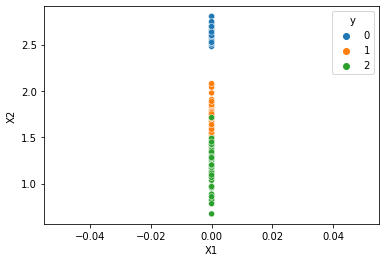

In [29]:
do_plot(X_enc_df, 'X1', 'X2', 'y')

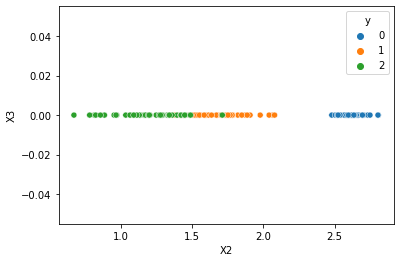

In [30]:
do_plot(X_enc_df, 'X2', 'X3', 'y')

In [31]:
do_plot(X_enc_df, 'X3', 'X4', 'y')

### Examine Data In Original Space

In [33]:
X_df = pd.DataFrame(X, columns = ['X1', 'X2', 'X3', 'X4'])
X_df['y'] = y_label

<AxesSubplot:xlabel='X1', ylabel='X2'>

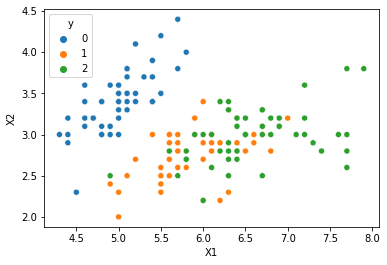

In [34]:
sns.scatterplot(data=X_df, x='X1', y='X2', hue = 'y')

<AxesSubplot:xlabel='X3', ylabel='X4'>

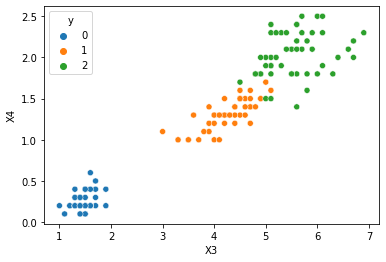

In [35]:
sns.scatterplot(data=X_df, x='X3', y='X4', hue = 'y')